<a href="https://colab.research.google.com/github/kheirie/Health-Pass-Tweets-Data-Analysis/blob/main/PassSanitaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Dependencies

In [2]:
%%capture
%cd drive/MyDrive/Sentiment-Analysis/Twitter-Pass-Sanitaire-Sentiment/data

!pip install googletrans==3.1.0a0
!pip install geopy 
!pip install pycountry 
!pip install geopandas 
!pip install geoplot 

In [3]:
# Data Processing and Analysis
import pandas as pd 

# Linear Algebra
import numpy as np  

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wordcloud import WordCloud
from PIL import Image

# Reading and Writing Files
import pickle 
import json 

# Translation
from googletrans import Translator

# Geocoding Webservices
from geopy.geocoders import Nominatim

# ISO database for standards - country codes
import pycountry

# Geospatial Data
import geopandas


# NLP 
import spacy  
import regex as re 
import string 

from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load('en_core_web_sm')

In [ ]:
#tweets_1 = pd.read_csv("df5.csv")
#tweets_2 = pd.read_csv("df6.csv")
#tweets_3 = pd.read_csv("df7.csv")
#tweets_4 = pd.read_csv("df8.csv")
#tweets_5 = pd.read_csv("df9.csv")
#tweets_6 = pd.read_csv("df10.csv")

#tweets = pd.concat([tweets_1, tweets_2, tweets_3, tweets_4, tweets_5, tweets_6], ignore_index=False).reset_index()
#tweets = tweets.drop_duplicates(subset=["text"])

#tweets.to_csv("all_tweets.csv", index=False)

# Read Tweets CSV file as a Pandas DataFrame

In [ ]:
tweets = pd.read_csv("all_tweets.csv")
tweets.head()

,index,user_name,user_location,user_description,user_verified,date,text,hashtags,source
0,0,Louis wilson,NaN,Pro choice - doing what's right - open to diff...,False,2021-08-17 14:39:42,"@glenry @McGiff This is NOT the same, a travel...",NaN,Twitter for iPhone
1,1,ClHunt,NaN,NaN,False,2021-08-17 14:39:20,@WorkBritneyJean @SouthernOver @kelly_kling @b...,NaN,Twitter Web App
2,2,Pires_01,Lionel Messi’s Trophy Room,"Believer in Jesus Christ, Phil 4:13. Not perfe...",False,2021-08-17 14:39:16,@joe_warmington this is the RN president of On...,NaN,Twitter for iPhone
3,3,Vintage Maria,"New York, NY",Balanced Boss Bitch™️✊🏽| MBA 🎓 •Real Estate Ex...,False,2021-08-17 14:38:22,Where’s the NYC vaccine passport protest??? I ...,NaN,Twitter for iPhone
4,4,SandileSN,South Africa,"Mzansian! Financial Freedom, Cryptocurrency, C...",False,2021-08-17 14:38:15,I love this!!! Screw #VaccinePassports\nhttps:...,['VaccinePassports'],Twitter Web App


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5385 entries, 0 to 5384
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             5385 non-null   int64 
 1   user_name         5385 non-null   object
 2   user_location     3552 non-null   object
 3   user_description  4455 non-null   object
 4   user_verified     5385 non-null   bool  
 5   date              5385 non-null   object
 6   text              5385 non-null   object
 7   hashtags          273 non-null    object
 8   source            5385 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 341.9+ KB


# Analyzing the Date Column

In [ ]:
# remove time from date column
tweets['date'] = pd.to_datetime(tweets['date']).dt.date
print(tweets['date'])

0       2021-08-17
1       2021-08-17
2       2021-08-17
3       2021-08-17
4       2021-08-17
           ...    
5380    2021-09-10
5381    2021-09-10
5382    2021-09-10
5383    2021-09-10
5384    2021-09-10
Name: date, Length: 5385, dtype: object


In [ ]:
tweets['date'].value_counts()

2021-08-17    1370
2021-08-27     900
2021-09-10     897
2021-09-03     896
2021-08-28     895
2021-08-18     427
Name: date, dtype: int64

# Analyzing the Location Column

## Creating List and Dictionary of locations

In [ ]:
# create a list of raw locations - i.e. locations entered by users
raw_locations = tweets.user_location.unique().tolist()
# replace nan by "" - the first element of the list is nan
raw_locations[0] = ""

# locations list will only include relevant locations
locations = []

# search for relevant locations and add them to the locations list
for loc in raw_locations:
  text = ""
  loc_ = nlp(loc) 
  for ent in loc_.ents: 
    if ent.label_ == "GPE": 
      text = text + " " + ent.text
      locations.append(text)
    else: 
      continue

In [ ]:
# Get the country name from cities' and states' names
countries = []

for loc in locations:
  geolocator = Nominatim(user_agent = "geoapiExercises")
  location = geolocator.geocode(loc, timeout=10000)

  if location == None: 
    countries.append(loc)
    continue

  location_ = nlp(location.address)

  if "," in location_.text: 
    # Examples of a location_.text: "New York, United States" or "London, Greater London, England, United Kingdom
    # get the name after the last ","
    countries.append(location_.text.split(",")[-1]) 
  else: 
    countries.append(location.address)
  
np.unique(np.array(countries))

In [ ]:
# get the last name only when "/" or "-" is found - "/" and "-" separates names in different languages
countries = [country.split("/")[-1] for country in countries]
countries = [country.split("-")[-1] for country in countries]
np.unique(np.array(countries))

array([' Aotearoa', ' Atlanta Seattle', ' Australia', ' Belgien',
       ' Brasil', ' Calgary Mohkinstis', ' Calgary Mohkinstis Alberta',
       ' Cameroun', ' Canada', ' Canterbury Region New Zealand',
       ' Detroit Las Vegas', ' Deutschland', ' Djillong',
       ' Djillong Victoria', ' Djillong Victoria Australia', ' España',
       ' Finland', ' France', ' France Switzerland California', ' India',
       ' Indonesia', ' Ireland', ' Italia', ' Jamaica', ' Kıbrıs',
       ' London Bxl Paris', ' London Edinburgh Ercan',
       ' London New York Hong Kong', ' Lpool NI', ' Luzon', ' Malaysia',
       ' México', ' Nederland', ' Nigeria',
       ' Peoples Republic of Francistan', ' Polska', ' Portugal',
       ' Romuld Island', ' Scottsdale AZ Calgary', ' Slovenija',
       ' South Africa', ' Soviet Canuckistan', ' Sverige',
       ' Toronto Hargeisa', ' Türkiye', ' Uganda', ' United Kingdom',
       ' United States', ' Yugambeh', ' Österreich', ' Ελλάς', ' Россия',
       ' الإمارات ال

In [ ]:
# remove white space found at the beginning of a string
countries = [country[1:] if country[0] == " " else country for country in countries]
np.unique(np.array(countries))

array(['Aotearoa', 'Argentina', 'Atlanta Seattle', 'Australia', 'Belgien',
       'Brasil', 'Calgary Mohkinstis', 'Calgary Mohkinstis Alberta',
       'Cameroun', 'Canada', 'Canterbury Region New Zealand', 'Danmark',
       'Detroit Las Vegas', 'Deutschland', 'Djillong',
       'Djillong Victoria', 'Djillong Victoria Australia', 'Eesti',
       'España', 'Finland', 'France', 'France Switzerland California',
       'Føroyar', 'Guernsey', 'Hungarian Empire', 'India', 'Indonesia',
       'Ireland', 'Italia', 'Jamaica', 'Kıbrıs', 'Lietuva',
       'London Bxl Paris', 'London Edinburgh Ercan',
       'London New York Hong Kong', 'Lpool NI', 'Luzon', 'Magyarország',
       'Malaysia', 'México', 'Nederland', 'Nigeria', 'Norge',
       'North Pole', 'Peoples Republic of Francistan', 'Perú',
       'Philippines', 'Polska', 'Portugal', 'Romuld Island',
       'Scottsdale AZ Calgary', 'Singapore', 'Slovenija', 'South Africa',
       'Soviet Canuckistan', 'Sverige', 'Svizra', 'The Bahamas',
      

In [ ]:
# Manually replace locations that are not country names to their relevant country name
countries = ['United States'  if country in ["LA", "Detroit Las Vegas", "Atlanta Seattle"] else country for country in countries]
countries = ['Canada'  if country in ["Calgary Mohkinstis", "Calgary Mohkinstis Alberta"] else country for country in countries]

np.unique(np.array(countries))

array(['Aotearoa', 'Argentina', 'Australia', 'Belgien', 'Brasil',
       'Cameroun', 'Canada', 'Canterbury Region New Zealand', 'Danmark',
       'Deutschland', 'Djillong', 'Djillong Victoria',
       'Djillong Victoria Australia', 'Eesti', 'España', 'Finland',
       'France', 'France Switzerland California', 'Føroyar', 'Guernsey',
       'Hungarian Empire', 'India', 'Indonesia', 'Ireland', 'Italia',
       'Jamaica', 'Kıbrıs', 'Lietuva', 'London Bxl Paris',
       'London Edinburgh Ercan', 'London New York Hong Kong', 'Lpool NI',
       'Luzon', 'Magyarország', 'Malaysia', 'México', 'Nederland',
       'Nigeria', 'Norge', 'North Pole', 'Peoples Republic of Francistan',
       'Perú', 'Philippines', 'Polska', 'Portugal', 'Romuld Island',
       'Scottsdale AZ Calgary', 'Singapore', 'Slovenija', 'South Africa',
       'Soviet Canuckistan', 'Sverige', 'Svizra', 'The Bahamas',
       'Toronto Hargeisa', 'Türkiye', 'Uganda', 'United Kingdom',
       'United States', 'Việt Nam', 'Yugambeh'

In [ ]:
# Translation
from googletrans import Translator

# get the last name only when "/" or "-" is found - "/" and "-" separates names in different languages
countries = [country.split("/")[-1] for country in countries]
countries = [country.split("-")[-1] for country in countries]

# remove white space found at the beginning of a string
countries = [country[1:] if country[0] == " " else country for country in countries]

# Manually replace locations that are not country names to their relevant country name
countries = ['United States'  if country in ["LA", "Detroit Las Vegas", "Atlanta Seattle"] 
             else country for country in countries]
countries = ['Canada'  if country in ["Calgary Mohkinstis", "Calgary Mohkinstis Alberta"] else country for country in countries]

# translate countries in foriegn language to english
translator = Translator()
countries = [translator.translate(country).text for country in countries]
print(len(countries))
print(np.unique(np.array(countries)))

1241
['Argentina' 'Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria'
 'Cameroon' 'Canada' 'Canterbury Region New Zealand' 'China' 'Cyprus'
 'D-class dragon hunting' 'Denmark' 'Djillong Victoria'
 'Djillong Victoria Australia' 'Egypt' 'Estonia' 'Faroe Islands' 'Finland'
 'France' 'France Switzerland California' 'Germany' 'Guernsey' 'Hellas'
 'Hungarian Empire' 'Iceland' 'India' 'Indonesia' 'Ireland' 'Italy'
 'Jamaica' 'Japan' 'Kingdom of Cambodia' 'Korea' 'Kuwait' 'Lithuania'
 'London Bxl Paris' 'London Edinburgh Ercan' 'London New York Hong Kong'
 'Luzon' 'Magyarország' 'Malaysia' 'Mexico' 'Morocco' 'New Zealand'
 'Nigeria' 'North Pole' 'Norway' 'Pakistan'
 'Peoples Republic of Francistan' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Romuld Island' 'Russia' 'Scottsdale AZ Calgary' 'Singapore' 'Slovenia'
 'South Africa' 'Soviet Canuckistan' 'Spain' 'Svizra' 'Sweden' 'Thailand'
 'The Bahamas' "The Democratic People's Republic of Korea"
 'The Netherlands' 'The United Arab Emirates' 'To L P

In [ ]:
# for those that were not translated properly add them manually
# unknown to be added to others later: joke To L Poo l  ދިވެހިރާއްޖެ
countries = ['Germany'  if country == "Deutschland" else country for country in countries]
countries = ['Spain'  if country == "España" else country for country in countries]
countries = ['Iceland'  if country == "Ísland" else country for country in countries]
countries = ['Greece'  if country == "Ελλάς" else country for country in countries]
countries = ['Ukraine'  if country == "Україна" else country for country in countries]
countries = ['Iran'  if country == "ایران" else country for country in countries]
countries = ['Japan'  if country == "日本" else country for country in countries]
countries = ['Svizra'  if country == "Switzerland" else country for country in countries]
countries = ['Polska'  if country == "Poland" else country for country in countries]
countries = ["The Democratic People's Republic of Korea"  if country == "조선민주주의인민공화국" else country for country in countries]


print(len(countries))
print(np.unique(np.array(countries)))


1241
['Argentina' 'Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria'
 'Cameroon' 'Canada' 'Canterbury Region New Zealand' 'China' 'Cyprus'
 'D-class dragon hunting' 'Denmark' 'Djillong Victoria'
 'Djillong Victoria Australia' 'Egypt' 'Estonia' 'Faroe Islands' 'Finland'
 'France' 'France Switzerland California' 'Germany' 'Guernsey' 'Hellas'
 'Hungarian Empire' 'Iceland' 'India' 'Indonesia' 'Iran' 'Ireland' 'Italy'
 'Jamaica' 'Japan' 'Kingdom of Cambodia' 'Korea' 'Kuwait' 'Lithuania'
 'London Bxl Paris' 'London Edinburgh Ercan' 'London New York Hong Kong'
 'Luzon' 'Magyarország' 'Malaysia' 'Mexico' 'Morocco' 'New Zealand'
 'Nigeria' 'North Pole' 'Norway' 'Pakistan'
 'Peoples Republic of Francistan' 'Peru' 'Philippines' 'Polska' 'Portugal'
 'Romuld Island' 'Russia' 'Scottsdale AZ Calgary' 'Singapore' 'Slovenia'
 'South Africa' 'Soviet Canuckistan' 'Spain' 'Svizra' 'Sweden' 'Thailand'
 'The Bahamas' "The Democratic People's Republic of Korea"
 'The Netherlands' 'The United Arab Emirates' 

In [18]:
#with open("countries_lst.txt", "wb") as fp:   #Pickling
  #pickle.dump(countries, fp)

with open("countries_lst.txt", "rb") as fp:   # Unpickling
  countries = pickle.load(fp)

In [20]:
len(countries)

1241

In [ ]:
from collections import Counter

# Use Counter to create a dictionary with all countries and their equivelant number of tweets
countries_values = Counter(countries)

# Create dictionary of the countries having the most tweets with their respective values and an element called "others" representing other countries
main_countries = {'others': 0}
other_countries = []
for key, val in countries_values.items(): 
  if val >= 20: 
    main_countries[key] = val
  else:
    main_countries["others"] += val
    other_countries.append(key)

print(main_countries)

{'others': 219, 'United States': 306, 'South Africa': 24, 'United Kingdom': 281, 'Canada': 309, 'France': 42, 'Australia': 60}


## Creating Geopandas DataFrame

In [ ]:
# create dataframe of country names and their codes
df_countries = pd.DataFrame()
df_countries["country_name"] = list(countries_values.keys())
df_countries["country_value"] = list(countries_values.values())

def get_cntry_code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df_countries["country_code"] = get_cntry_code(df_countries.country_name)
df_countries.head()

,country_name,country_value,country_code
0,United States,306,USA
1,South Africa,24,ZAF
2,United Kingdom,281,GBR
3,Norway,1,NOR
4,Canada,309,CAN


In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [ ]:
# This needs to be fixed - for some countries iso_a3 codes are set as -99
world.loc[world["iso_a3"]=="-99"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. Cyprus,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,Somaliland,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [ ]:
# solution 
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [ ]:
# rename columns to merge the dataframes
world = world.rename(columns={"iso_a3": "country_code"})
df_merged = pd.merge(world, df_countries, on="country_code", how='outer')
# fill empty value with zero - any country with no tweet will have a value of 0
df_merged.country_value = df_merged.country_value.fillna(0)

## Plotting the Map and Pie Chart to show the locations that the tweets come from 

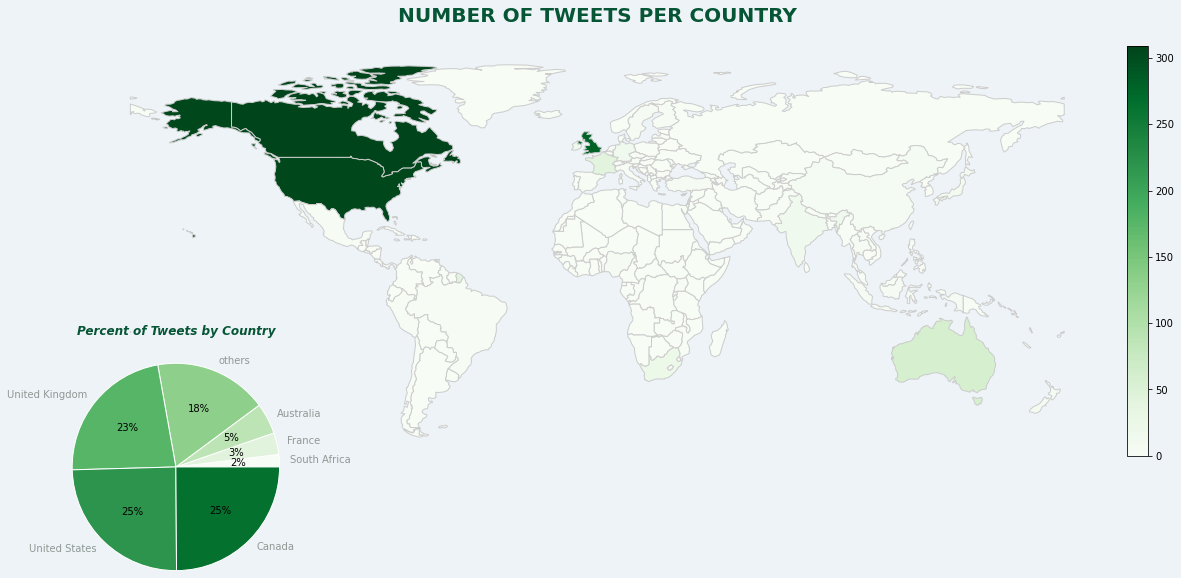

In [ ]:
fig = plt.figure(figsize=(15,10), facecolor='#eef3f8')

ax1=fig.add_axes([0, 0, 1, 1]) # the map
ax2=fig.add_axes([0, 0.1, 0.2, 0.2]) # the pie chart

divider = divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0) # the legend of the map

### MAP ###

df_merged=df_merged[(df_merged.name != "Antarctica") & (df_merged.name != "Fr. S. Antarctic Lands")]
df_merged.to_crs(epsg=4326, inplace=True)
df_merged.plot(column='country_value', cmap='Greens', linewidth=1.0, ax=ax1, edgecolor='0.8', legend=True, cax=cax)

# remove axis 
ax1.axis('off')

# add a title of the map
ax1.set_title('NUMBER OF TWEETS PER COUNTRY', fontdict={'fontsize': '20', 'fontweight' : 'bold', 'color': '#065535', }, pad=24)

### PIE CHART ###

total = len(countries) # 1241

# Sort the dictionary - this is only for the sake of visualization
sorted_main_countries = dict(sorted(main_countries.items(), key=lambda x: x[1]))

# get labels for pie chart
labels = list(sorted_main_countries.keys())

# get percentages for pie chart
percentages = [(val/total)*100 for val in list(sorted_main_countries.values())]

# get theme colors to be coherent with that of the map's colors
theme = plt.get_cmap('Greens')
ax2.set_prop_cycle("color", [theme(1. * i / len(percentages))
                             for i in range(len(percentages))])

_, texts, autotexts = ax2.pie(percentages, labels = labels, labeldistance=1.1, autopct='%.0f%%', radius=1.8,  
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })

# set color for the autotext
for auto in autotexts:
    auto.set_color('black')

# set color of the labels
for text in texts:
    text.set_color('#909994')

# add a title for the pie chart
ax2.set_title('Percent of Tweets by Country', fontdict={'fontsize': '12', 'fontweight': 'bold', 'color': '#065535'}, pad=60, style='oblique')

# save figure
plt.savefig("no_of_tweets_per_country.png", bbox_inches = 'tight', facecolor='#eef3f8')
plt.show()



# Anaylzing the Text Column

## Text Preprocessing

In [ ]:
%%capture

# convert to lower case 
tweets["text_processed"] = ""
tweets["text_processed"] = tweets["text"].apply(
                               lambda x: str.lower(x))

# remove URL 
tweets["text_processed"] = tweets["text_processed"].apply(lambda x: 
                                  re.sub(r"(?:\@|http?\://|https?\://|www)\S+",
                                           ' ', x))

# convert slang - before removing special characters since some slangs include special characters 
# load slang dictionary
with open('slangdict.json') as json_file: 
  slang_dict=json.load(json_file)

for i in range(len(tweets["text_processed"])):
  txt = ""
  doc = nlp(tweets["text_processed"].iloc[i])

  for token in doc: 
    if token.text in list(slang_dict.keys()):
      txt = txt + " " + slang_dict[token.text]
    else: 
      txt = txt + " " + token.text
  
  tweets["text_processed"].iloc[i] = txt


In [ ]:
# remove mentions 
def remove_entities(text, entity_list):
  for separator in string.punctuation:
      if separator not in entity_list:
          text = text.replace(separator,' ')
  words = []
  for word in text.split():
      word = word.strip()
      if word:
          if word[0] not in entity_list:
              words.append(word)
  return ' '.join(words)

tweets["text_processed"] = tweets["text_processed"].apply(lambda x: remove_entities(x, ["@"]))

# remove punctuation 
tweets["text_processed"] = tweets["text_processed"].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

In [ ]:
# remove punctuation 
tweets["text_processed"] = tweets["text_processed"].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

In [ ]:
# lemmatize
%%capture

def lemmatize(sentence):
    doc = nlp(sentence) # tokenize the text and produce a Doc Object
    lemmas =  [token.lemma_ for token in doc]
    return " ".join(lemmas)

tweets["text_processed"] = tweets["text_processed"].apply(lambda x: lemmatize(x))

In [ ]:
# remove stopwords
%%capture

def remove_stopwords(sentence): 
  
    doc = nlp(sentence) # tokenize the text and produce a Doc Object
    all_stopwords = nlp.Defaults.stop_words
    doc_tokens = [token.text for token in doc]
    tokens_without_sw = [word for word in doc_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

tweets["text_processed"] = tweets["text_processed"].apply(lambda x: remove_stopwords(x))

# remove -PRON- a result of lemmatization
tweets["text_processed"] = tweets["text_processed"].apply(lambda x: re.sub('-PRON-', " ", x))
# remove numbers
tweets["text_processed"] = tweets["text_processed"].apply(lambda x: re.sub(r'[0-9]', " ", x))

In [ ]:
# remove country and city names
def remove_country_city(sentence): 
  doc = nlp(sentence)
  return (" ".join([ent.text for ent in doc if not ent.ent_type_]))

tweets["text_processed"] = tweets["text_processed"].apply(lambda x: remove_country_city(x) if pd.isna(x) != True else x)

In [ ]:
tweets["text_processed"] = tweets.text_processed.fillna(" ")
tweets = tweets[tweets["text_processed"]!= " "]

In [3]:
#tweets.to_csv("all_tweets_pr.csv", index=False)
#tweets = pd.read_csv("all_tweets_pr.csv")
#tweets = tweets.dropna(axis=0, subset=['text_processed'])
#tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5379 entries, 0 to 5384
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             5379 non-null   int64 
 1   user_name         5379 non-null   object
 2   user_location     3547 non-null   object
 3   user_description  4449 non-null   object
 4   user_verified     5379 non-null   bool  
 5   date              5379 non-null   object
 6   text              5379 non-null   object
 7   hashtags          273 non-null    object
 8   source            5379 non-null   object
 9   text_processed    5379 non-null   object
dtypes: bool(1), int64(1), object(8)
memory usage: 425.5+ KB


## World Cloud

### First Way through a Text

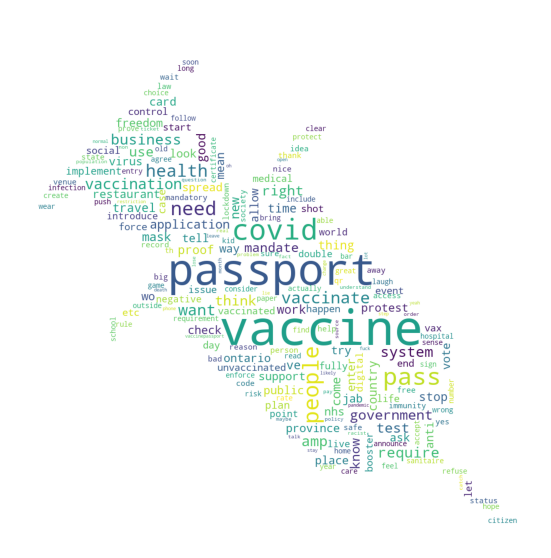

In [ ]:
# mask is the image used to reshape the cloud
mask = np.array(Image.open('syringe44_.jpeg'))

text = " ".join(tw for tw in tweets["text_processed"])

word_cloud = WordCloud(collocations = False, background_color = 'white', 
                       max_words=200, width=3000, height=2000,
                       colormap='viridis', mask=mask).generate(text)
plt.figure(figsize=[15,10])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
word_cloud.to_file("ps_word_cloud.png")

### Second Way through TFIDF Unigrams

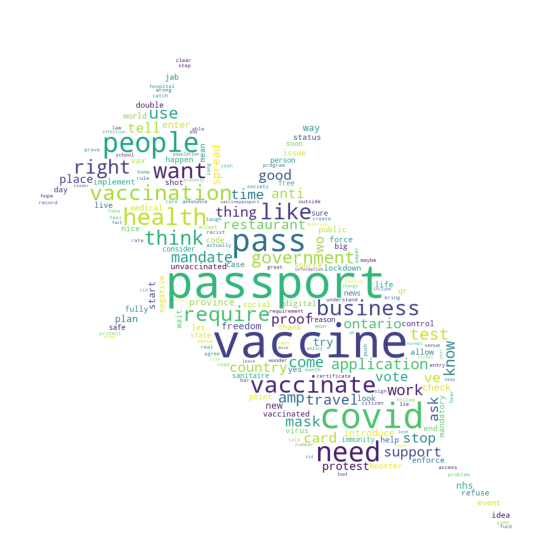

In [7]:
vectorizor = TfidfVectorizer(stop_words='english')
vecs = vectorizor.fit_transform(tweets.text_processed)

feature_names = vectorizor.get_feature_names()
dense = vecs.todense()
l = dense.tolist()
df = pd.DataFrame(l, columns=feature_names)

# mask is the image used to reshape the cloud
mask = np.array(Image.open('./images/syringe44_.jpeg'))


word_cloud = WordCloud(collocations = False, background_color = 'white', 
                       max_words=200, width=3000, height=2000,
                       colormap='viridis', mask=mask).generate_from_frequencies(df.T.sum(axis=1))
plt.figure(figsize=[15,10])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
word_cloud.to_file("tfidf_ps_word_cloud.png")

## Bigrams and Trigrams

### Obtaining and saving the bigrams and Trigrams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#bigrams
vectorizor = TfidfVectorizer(stop_words='english', ngram_range =(2, 2))

#trigrams
#vectorizor = TfidfVectorizer(stop_words='english', ngram_range =(3, 3))

vecs = vectorizor.fit_transform(tweets.text_processed)

feature_names = vectorizor.get_feature_names()
dense = vecs.todense()
l = dense.tolist()
df = pd.DataFrame(l, columns=feature_names)

n_grams = df.T.sum(axis=1).sort_values(ascending=False)

n_grams.to_csv("bigrams.csv")
#n_grams.to_csv("trigrams.csv")

In [4]:
# bigrams
vectorizor = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))

# trigrams
#vectorizor = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))

# to avoid running out of RAM, divide the dataframe
vecs = vectorizor.fit_transform(tweets.text_processed[:2000])
#vecs = vectorizor.fit_transform(tweets.text_processed[2000:])


feature_names = vectorizor.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

n_grams = df.T.sum(axis=1).sort_values(ascending=False)


# Save Results
#n_grams.to_csv("bigrams1.csv")
#n_grams.to_csv("bigrams2.csv")
#n_grams.to_csv("trigrams1.csv")
#n_grams.to_csv("trigrams2.csv")

In [8]:
#bigrams1 = pd.read_csv("bigrams1.csv", index_col=False, names=["bigram", "value"])
#bigrams2 = pd.read_csv("bigrams2.csv", index_col=False, names=["bigram", "value"])
#bigrams = pd.concat([bigrams1, bigrams2], ignore_index=False).reset_index()
#bigrams.to_csv("bigrams.csv")
bigrams = pd.read_csv("bigrams.csv")
bigrams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38420 entries, 0 to 38419
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  38420 non-null  int64  
 1   index       38420 non-null  int64  
 2   bigram      38418 non-null  object 
 3   value       38420 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [4]:
#trigrams1 = pd.read_csv("trigrams1.csv", index_col=False, names=["trigram", "value"])
#trigrams2 = pd.read_csv("trigrams2.csv", index_col=False, names=["trigram", "value"])
#trigrams = pd.concat([trigrams1, trigrams2], ignore_index=False).reset_index()
#trigrams.to_csv("trigrams.csv")
trigrams=pd.read_csv("trigrams.csv")
trigrams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43280 entries, 0 to 43279
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  43280 non-null  int64  
 1   index       43280 non-null  int64  
 2   trigram     43278 non-null  object 
 3   value       43280 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB


### Plotting the top bigrams and trigrams

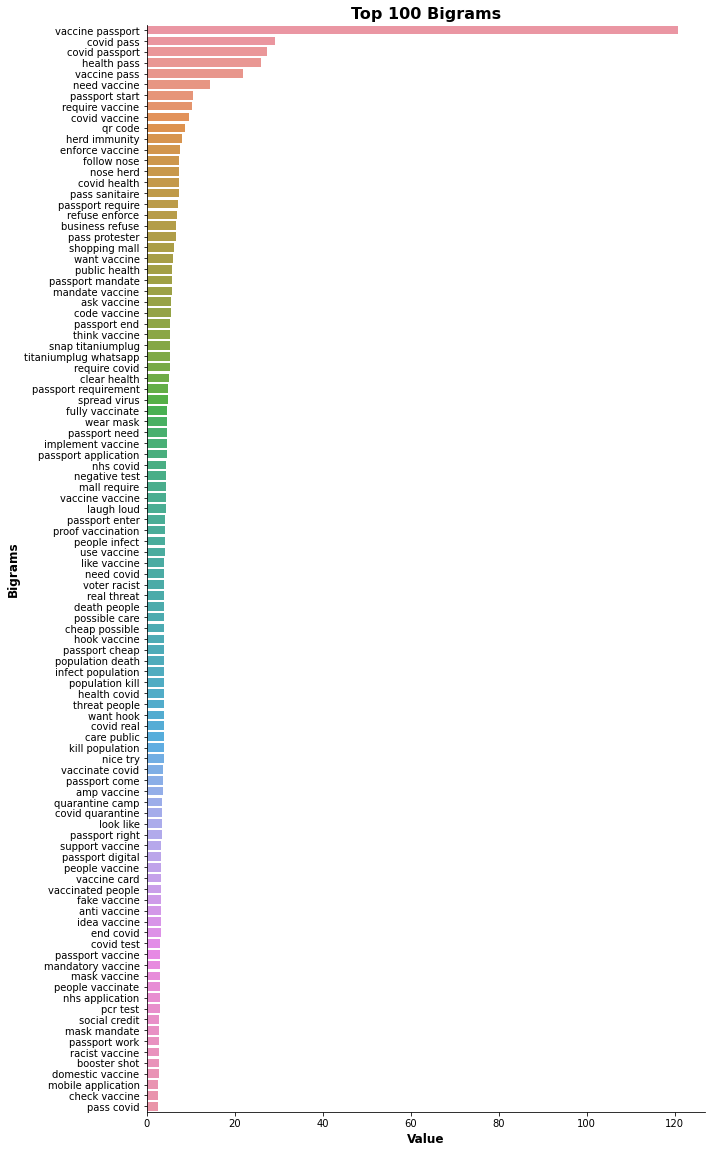

In [10]:
# plot bar graph
plt.figure(figsize=(10,20))
sns.barplot(x = bigrams[:101].value , y = bigrams[:101].bigram)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("Value", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.ylabel("Bigrams", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.title("Top 100 Bigrams", fontdict={'fontsize': '16', 'fontweight' : 'bold'})
plt.savefig("Top 100 Bigrams.png", bbox_inches = 'tight')

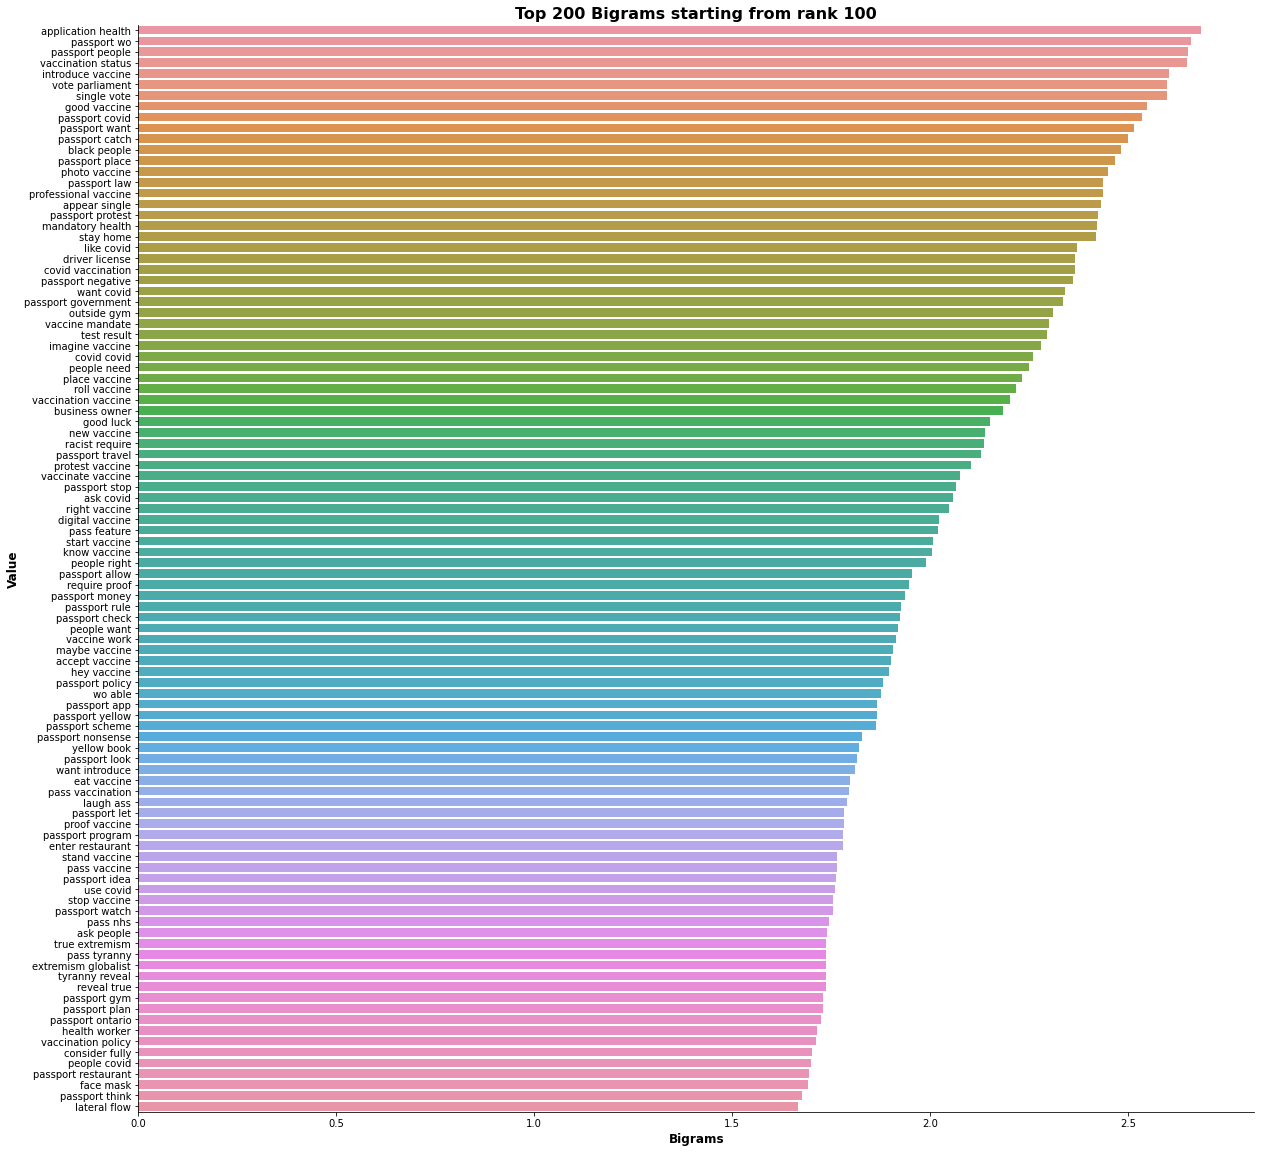

In [9]:
plt.figure(figsize=(20,20))
sns.barplot(y = bigrams[101:201].bigram, x = bigrams[101:201].value)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("Bigrams", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.ylabel("Value", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.title("Top 200 Bigrams starting from rank 100", fontdict={'fontsize': '16', 'fontweight' : 'bold'})
plt.savefig("Top 100 - 200 Bigrams", bbox_inches = 'tight')

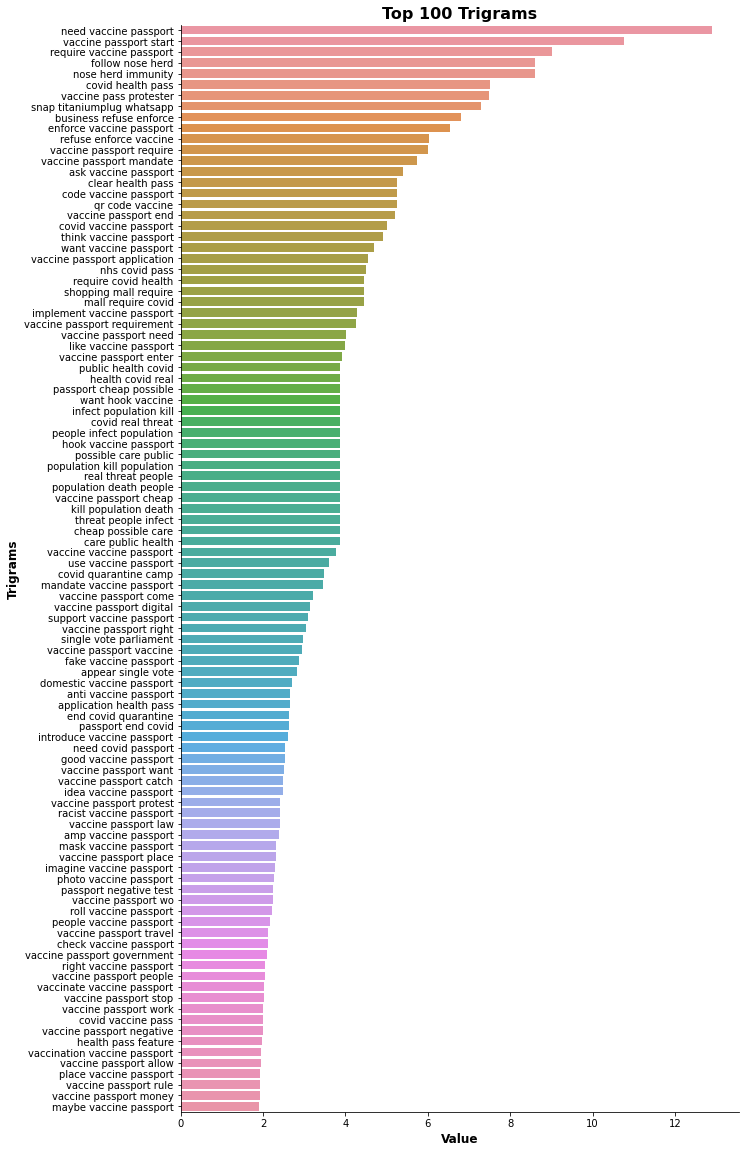

In [7]:
plt.figure(figsize=(10,20))
sns.barplot(y = trigrams[:101].trigram, x = trigrams[:101].value)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("Value", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.ylabel("Trigrams", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.title("Top 100 Trigrams", fontdict={'fontsize': '16', 'fontweight' : 'bold'})
plt.savefig("Top 100 Trigrams.png", bbox_inches = 'tight')

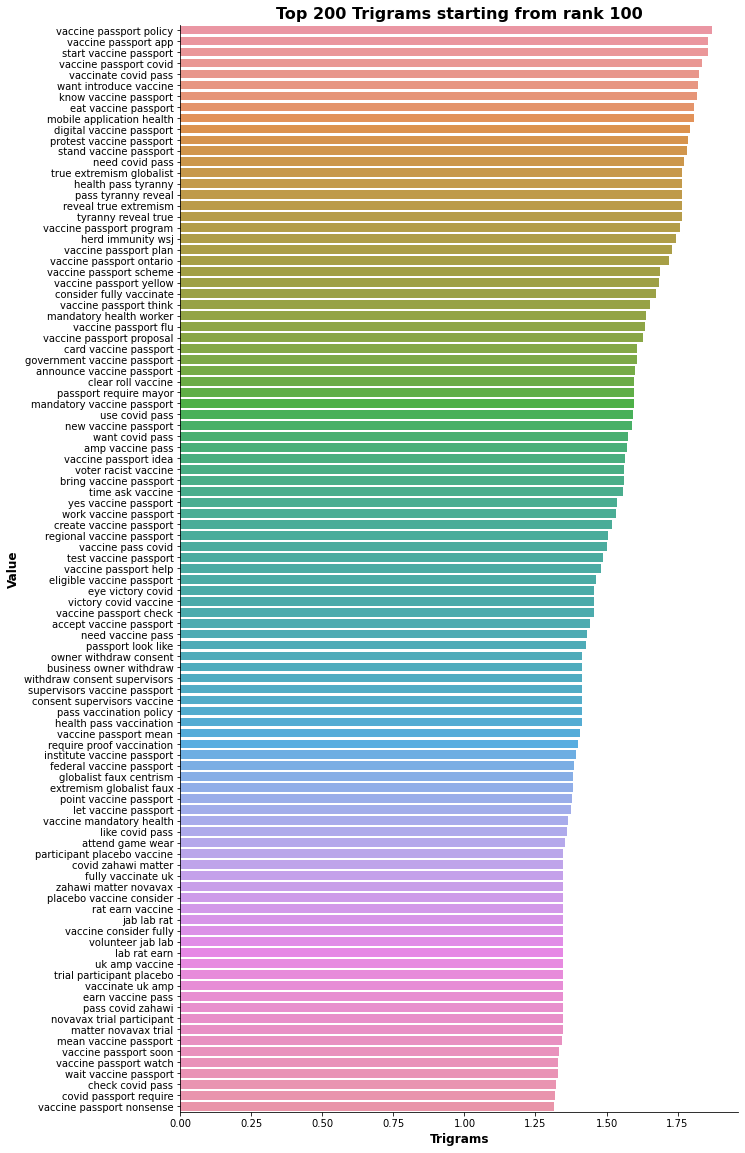

In [6]:
plt.figure(figsize=(10,20))
sns.barplot(x = trigrams[101:201].value, y = trigrams[101:200].trigram)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("Trigrams", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.ylabel("Value", fontdict={'fontsize': '12', 'fontweight' : 'bold'})
plt.title("Top 200 Trigrams starting from rank 100", fontdict={'fontsize': '16', 'fontweight' : 'bold'})
plt.savefig("Top 100 - 200 Trigrams", bbox_inches = 'tight')